# Train XGBoost model

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from pathlib import Path

In [2]:
from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix

In [3]:
import xgboost as xgb

In [4]:
import os
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/hh_micro_mono/")
os.chdir(root_dir / "DMR_classifier")

In [5]:
adata = sc.read_h5ad("dmr_regions-CGN_hypo_score.h5ad")
metadata = pd.read_csv("dmr_regions-CGN_hypo_score-meta_sub.tsv", sep="\t", header=0, index_col=0)

In [6]:
metadata["ct_raw"] = metadata["celltype"].copy()
ext = ["CA", "DG", "SUB"]
metadata.loc[metadata["celltype"].isin(ext), "celltype"] = "Exc_Neurons"
inh = ["PVALB", "SST", "VIP", "NR2F2-LAMP5"]
metadata.loc[metadata["celltype"].isin(inh), "celltype"] = "Inh_Neurons"

In [7]:
included_ct = [
    "Exc_Neurons", "Inh_Neurons",
    "Astro", "Oligo", "OPC", "Endo-VLMC",
    # "Endo_Lym_Skn", "Fibro_Mus", "Mast_Skn", "Mono2",
    # "NK_CD16_Bld", "Tnaive_CD4_1", 
    "infant_MGC-1"
]

In [8]:
binarize_matrix(adata, cutoff=0.95)

In [9]:
micro_adata = adata[metadata[metadata["celltype"].isin(["Micro1", "Micro2"])].index, :].copy()
adata = adata[metadata[metadata["celltype"].isin(included_ct)].index, :].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 3720 × 601220
    obs: 'allc_path', 'celltype'
    var: 'chrom', 'end', 'start'

In [11]:
micro_adata

AnnData object with n_obs × n_vars = 1000 × 601220
    obs: 'allc_path', 'celltype'
    var: 'chrom', 'end', 'start'

# Initial training

In [12]:
X = adata.X
y = metadata.loc[adata.obs_names, "celltype"].values
le = LabelEncoder()
y_numeric = le.fit_transform(y)

In [13]:
le.classes_

array(['Astro', 'Endo-VLMC', 'Exc_Neurons', 'Inh_Neurons', 'OPC', 'Oligo',
       'infant_MGC-1'], dtype=object)

In [14]:
# Train: Eval: Test in 7:2:1 ratio
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_numeric, test_size=0.1, random_state=42, stratify=y_numeric
)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_temp, y_temp, test_size=2/9, random_state=42, stratify=y_temp
)

In [15]:
# Load data onto XGBoost GPU support
dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_eval, label=y_eval)
dtest = xgb.DMatrix(X_test, label=y_test)

In [16]:
## Accuracy calculation
num_classes = len(np.unique(y_numeric))
def accuracy_eval(preds, dmatrix):
    labels = dmatrix.get_label().astype(int)
    preds = preds.reshape(-1, num_classes)
    pred_labels = np.argmax(preds, axis=1)
    acc = np.mean(pred_labels == labels)
    return "accuracy", acc

In [17]:
print(num_classes)

7


In [18]:
print(len(metadata["celltype"].unique()))

25


## Training step

In [19]:
params = {
    "objective": "multi:softprob",
    "num_class": num_classes,
    "tree_method": "hist",
    "device": "cuda",
    "max_depth": 4,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.4,
    "reg_lambda": 1.0,
    "reg_alpha": 0.1,
    "eval_metric": "mlogloss",
    "random_state": 42
}

In [20]:
evals = [(dtrain, "train"), (deval, "eval")]
evals_result = {}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=evals,
    custom_metric=accuracy_eval,
    evals_result=evals_result,
    early_stopping_rounds=5000,
    verbose_eval=50
)

[0]	train-mlogloss:1.93483	train-accuracy:0.57488	eval-mlogloss:1.93645	eval-accuracy:0.49866
[50]	train-mlogloss:1.51049	train-accuracy:0.81912	eval-mlogloss:1.56657	eval-accuracy:0.75269
[100]	train-mlogloss:1.25134	train-accuracy:0.83487	eval-mlogloss:1.34208	eval-accuracy:0.75806
[150]	train-mlogloss:1.06988	train-accuracy:0.84409	eval-mlogloss:1.18616	eval-accuracy:0.77419
[200]	train-mlogloss:0.93560	train-accuracy:0.85983	eval-mlogloss:1.06906	eval-accuracy:0.77554
[250]	train-mlogloss:0.83093	train-accuracy:0.86982	eval-mlogloss:0.97676	eval-accuracy:0.78629
[300]	train-mlogloss:0.74673	train-accuracy:0.88134	eval-mlogloss:0.90351	eval-accuracy:0.79839
[350]	train-mlogloss:0.67713	train-accuracy:0.89363	eval-mlogloss:0.84197	eval-accuracy:0.81048
[400]	train-mlogloss:0.61788	train-accuracy:0.90745	eval-mlogloss:0.79091	eval-accuracy:0.81452
[450]	train-mlogloss:0.56790	train-accuracy:0.91513	eval-mlogloss:0.74700	eval-accuracy:0.82258
[500]	train-mlogloss:0.52430	train-accuracy

In [21]:
eval_logloss = evals_result["eval"]["mlogloss"]
best_iter = int(np.argmin(eval_logloss))
print(best_iter)
best_score = float(np.min(eval_logloss))

4999


In [22]:
bst.save_model("models/hypo-score_binarized_20251013.json")

### After training

In [23]:
bst = xgb.Booster()
bst.load_model("models/hypo-score_binarized_20251013.json")

In [22]:
best_iter = 4999
y_pred_proba = bst.predict(dtest, iteration_range=(0, best_iter + 1))
y_pred = np.argmax(y_pred_proba, axis=1)

In [23]:
order = included_ct

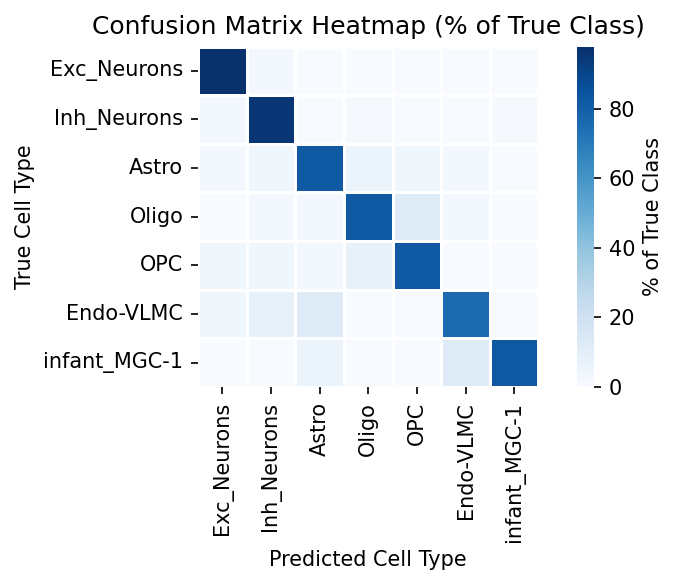

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create heatmap
cm = confusion_matrix(y_test, y_pred, normalize="true") * 100
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df = cm_df.loc[order, order]
plt.figure(figsize=(6, 4), dpi=150)
sns.heatmap(
    cm_df,
    cmap="Blues",
    cbar_kws={"label": "% of True Class"},
    square=True,
    annot=False,
    linewidths=0.5
)

plt.title("Confusion Matrix Heatmap (% of True Class)")
plt.xlabel("Predicted Cell Type")
plt.ylabel("True Cell Type")
plt.tight_layout()
plt.show()

In [25]:
dmicro = xgb.DMatrix(micro_adata.X)

In [26]:
micro_pred_prob = bst.predict(dmicro, iteration_range=(0, best_iter + 1))
micro_pred = np.argmax(micro_pred_prob, axis=1)

In [27]:
pred_df = pd.DataFrame({
    "cell_id": micro_adata.obs_names,
    "true_type": metadata.loc[micro_adata.obs_names, "celltype"],
    "predicted_type": le.inverse_transform(micro_pred),
})

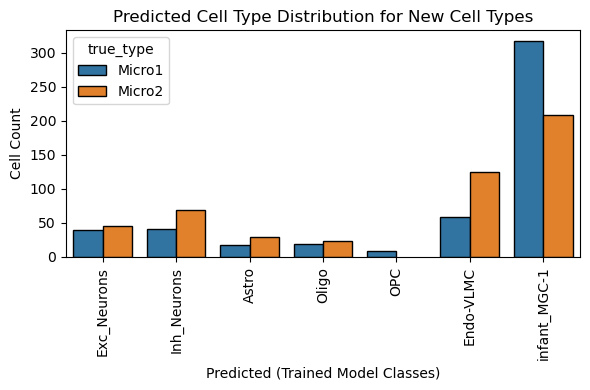

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(data=pred_df, x="predicted_type", hue="true_type", order=order, edgecolor="black")
plt.title("Predicted Cell Type Distribution for New Cell Types")
plt.xlabel("Predicted (Trained Model Classes)")
plt.ylabel("Cell Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [29]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
# proba_df = pd.DataFrame(
#     gaussian_filter1d(micro_pred_prob, sigma=1, axis=1, mode="nearest"),
#     columns=le.classes_,
#     index=micro_adata.obs_names
# )
proba_df = pd.DataFrame(micro_pred_prob, columns=le.classes_)
proba_df["celltype"] = micro_adata.obs["celltype"].values
proba_df["cell_id"] = micro_adata.obs_names.values
proba_long = proba_df.melt(
    id_vars=["cell_id", "celltype"],
    var_name="predicted_class",
    value_name="probability"
)
proba_long["predicted_class"] = pd.Categorical(proba_long["predicted_class"], categories=order)

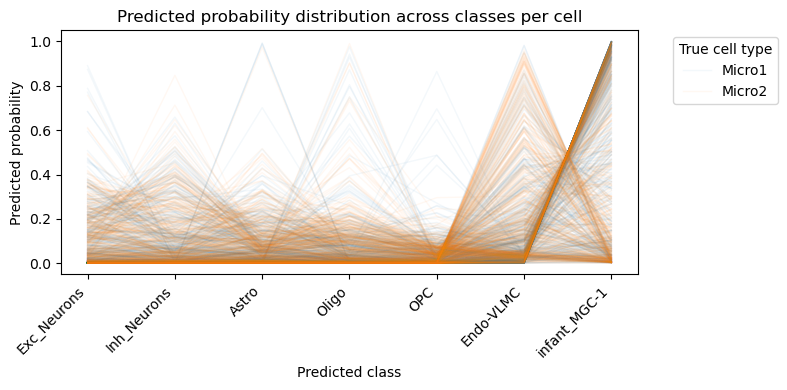

In [30]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=proba_long,
    x="predicted_class",
    y="probability",
    hue="celltype",
    units="cell_id",
    estimator=None,
    lw=1,
    alpha=0.05,
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted probability")
plt.xlabel("Predicted class")
plt.title("Predicted probability distribution across classes per cell")
plt.legend(title="True cell type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [33]:
entropy = -np.sum(micro_pred_prob * np.log(micro_pred_prob + 1e-12), axis=1)
entropy /= np.log(micro_pred_prob.shape[1])
sorted_prob = np.sort(micro_pred_prob, axis=1)
margin = sorted_prob[:, -1] - sorted_prob[:, -2]
proba_max_value = pd.DataFrame({
    "max_value": np.max(micro_pred_prob, axis=1),
    "entropy": entropy,
    "margin": margin,
    "celltype": micro_adata.obs["celltype"].values,
    "prediction": le.inverse_transform(micro_pred),
    "cell_id": micro_adata.obs_names,
    "cov": metadata.loc[micro_adata.obs_names, "total_cov"]
})

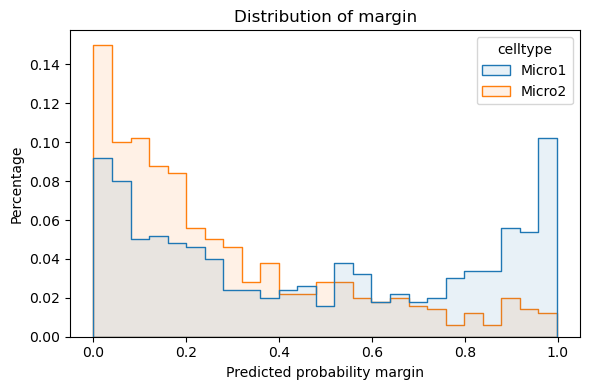

In [34]:
plt.figure(figsize=(6, 4))
sns.histplot(
    data=proba_max_value,
    x="margin",
    hue="celltype",
    alpha=0.1,
    element="step",
    common_norm=False,
    stat="proportion",
    bins=25,
    # edgecolor="black"
)

plt.ylabel("Percentage")
plt.xlabel("Predicted probability margin")
plt.title("Distribution of margin")
# plt.legend(title="True cell type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

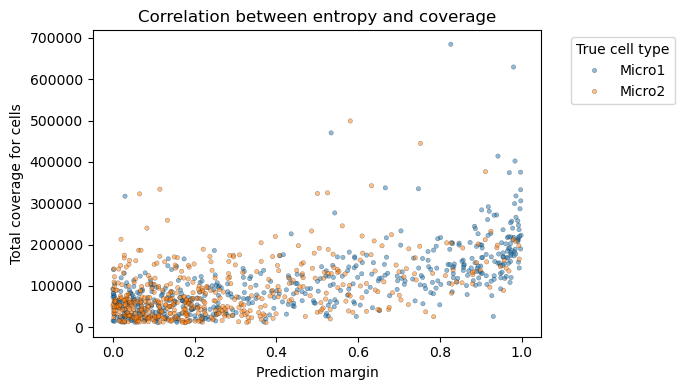

In [35]:
plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=proba_max_value,
    x="margin",
    y="cov",
    hue="celltype",
    edgecolor="black",
    alpha=0.5,
    s=10
)

plt.ylabel("Total coverage for cells")
plt.xlabel("Prediction margin")
plt.title("Correlation between entropy and coverage")
plt.legend(title="True cell type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

/scratch/biy022/job_7621055/ipykernel_629603/3117987568.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(
/scratch/biy022/job_7621055/ipykernel_629603/3117987568.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(


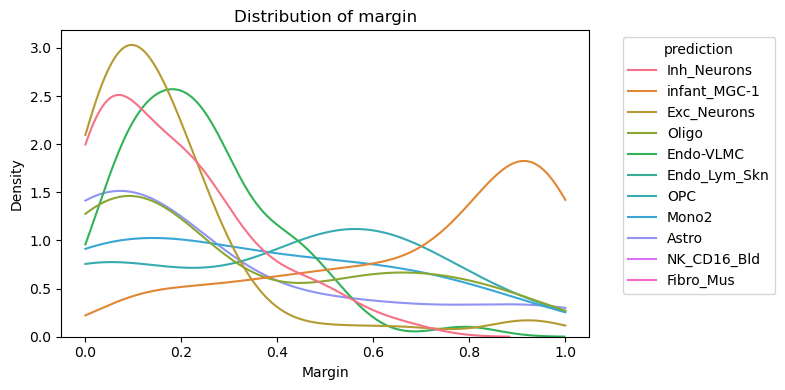

In [36]:
plt.figure(figsize=(8, 4))
ax = sns.kdeplot(
    data=proba_max_value[proba_max_value["celltype"] == "Micro1"],
    x="margin",
    hue="prediction",
    common_norm=False,
    clip=[0, 1]
)

leg = ax.legend_
leg.set_bbox_to_anchor((1.05, 1))
plt.ylabel("Density")
plt.xlabel("Margin")
plt.title("Distribution of margin")
plt.tight_layout()
plt.show()

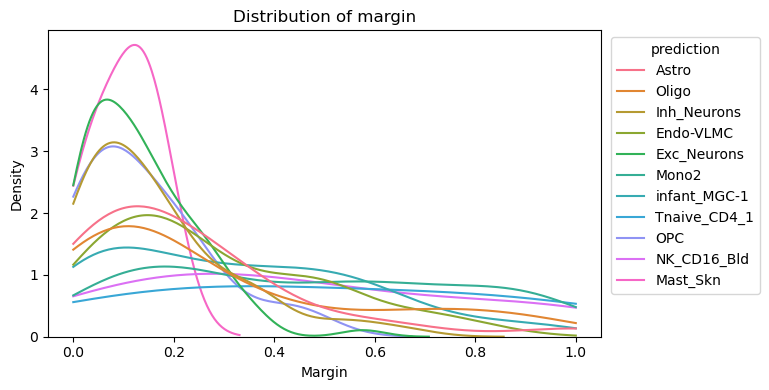

In [37]:
plt.figure(figsize=(8, 4))
ax = sns.kdeplot(
    data=proba_max_value[proba_max_value["celltype"] == "Micro2"],
    x="margin",
    hue="prediction",
    common_norm=False,
    clip=[0, 1]
)

leg = ax.legend_
leg.set_bbox_to_anchor((1.3, 1))
plt.ylabel("Density")
plt.xlabel("Margin")
plt.title("Distribution of margin")
plt.tight_layout()
plt.show()

# Plot models

In [38]:
bst = xgb.Booster()
bst.load_model("models/hypo-score_binarized_20251013.json")

In [39]:
importance = bst.get_score(importance_type="gain")
importance_df = (
    pd.DataFrame(list(importance.items()), columns=["feature", "importance"])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

In [40]:
importance_df.shape

(18830, 2)

In [41]:
topN = int(importance_df.shape[0] * 0.05)
importance_df["region"] = [adata.var_names[int(f[1:])] for f in importance_df["feature"]]
top_regions = importance_df["region"].head(topN).values

In [42]:
order = included_ct

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

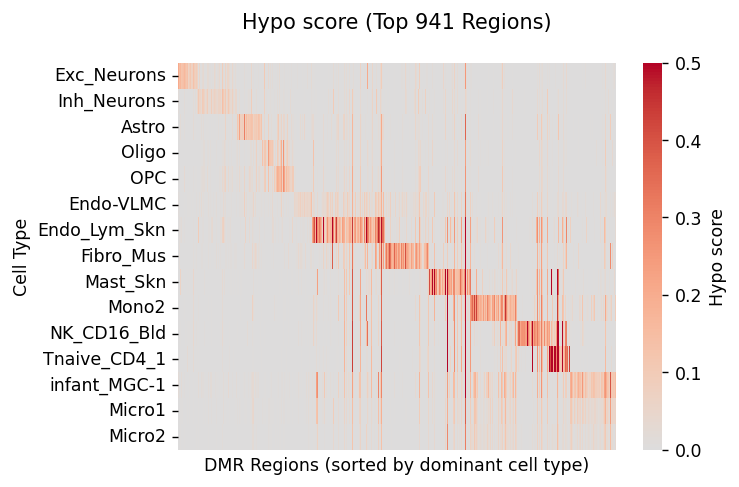

In [44]:
adata.obs["celltype"] = metadata.loc[adata.obs_names, "celltype"]
adata_top = adata[:, top_regions].copy()
adata_top.obs["celltype"] = pd.Categorical(adata_top.obs["celltype"], categories=order, ordered=True)
adata_top = adata_top[adata_top.obs.sort_values("celltype").index, :]

X = adata_top.X.toarray() if hasattr(adata_top.X, "toarray") else adata_top.X
df = pd.DataFrame(X, index=adata_top.obs["celltype"], columns=adata_top.var_names)
mean_by_type = df.groupby(level=0).mean()
dominant_celltype = mean_by_type.idxmax(axis=0)
celltype_order = mean_by_type.index.tolist()
dominant_rank = dominant_celltype.map({ct: i for i, ct in enumerate(celltype_order)})
sorted_columns = (
    mean_by_type.loc[:, dominant_rank.sort_values(kind="stable").index]
    .columns.tolist()
)
mean_sorted = mean_by_type.loc[celltype_order, sorted_columns]

micro_top = micro_adata[:, sorted_columns]
micro_top = micro_top[micro_top.obs.sort_values("celltype").index, :]
X_micro = micro_top.X.toarray() if hasattr(micro_top.X, "toarray") else micro_top.X
df = pd.DataFrame(X_micro, index=micro_top.obs["celltype"], columns=micro_top.var_names)
micro_mean = df.groupby(level=0).mean()
mean_sorted = pd.concat([mean_sorted, micro_mean], axis=0)

# mean_z = (mean_sorted - mean_sorted.mean(axis=1).values[:, None]) / mean_sorted.std(axis=1).values[:, None]

plt.figure(figsize=(6, 4), dpi=125)
sns.heatmap(
    mean_sorted,
    cmap="coolwarm",
    center=0,
    xticklabels=False,
    yticklabels=True,
    cbar_kws={"label": "Hypo score"},
    vmin=0,
    vmax=0.5,
    
)

plt.title("Hypo score (Top {} Regions)".format(topN), pad=20)
plt.xlabel("DMR Regions (sorted by dominant cell type)")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

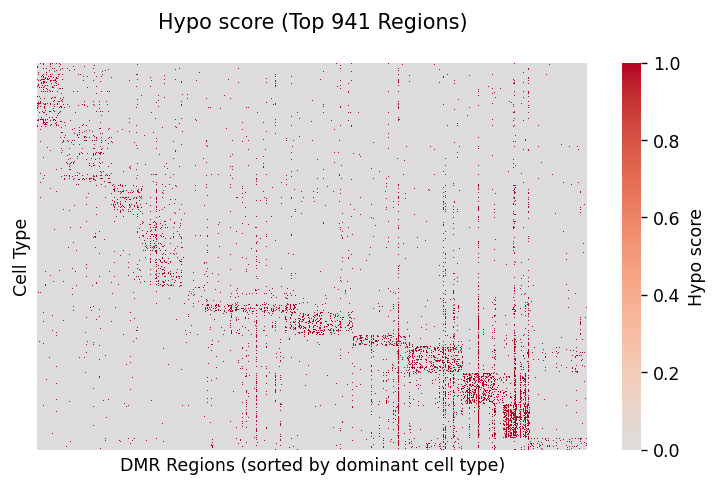

In [45]:
adata_top = adata[:, top_regions].copy()
adata_top.obs["celltype"] = pd.Categorical(adata_top.obs["celltype"], categories=order, ordered=True)
adata_top = adata_top[adata_top.obs.sort_values("celltype").index, :]

X = adata_top.X.toarray() if hasattr(adata_top.X, "toarray") else adata_top.X
df = pd.DataFrame(X, index=adata_top.obs_names, columns=adata_top.var_names)
mean_by_type = df.groupby(adata_top.obs["celltype"]).mean()
dominant_celltype = mean_by_type.idxmax(axis=0)
celltype_order = mean_by_type.index.tolist()
dominant_rank = dominant_celltype.map({ct: i for i, ct in enumerate(celltype_order)})
sorted_columns = (
    mean_by_type.loc[:, dominant_rank.sort_values(kind="stable").index]
    .columns.tolist()
)
mean_sorted = df[sorted_columns]
# mean_z = (mean_sorted - mean_sorted.mean(axis=1).values[:, None]) / mean_sorted.std(axis=1).values[:, None]

plt.figure(figsize=(6, 4), dpi=125)
sns.heatmap(
    mean_sorted,
    cmap="coolwarm",
    center=0,
    xticklabels=False,
    yticklabels=False,
    cbar_kws={"label": "Hypo score"},
    vmin=0,
    vmax=1.0,
    
)

plt.title("Hypo score (Top {} Regions)".format(topN), pad=20)
plt.xlabel("DMR Regions (sorted by dominant cell type)")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

In [46]:
metadata = pd.read_csv("allc_meta.tsv", sep="\t", header=0, index_col=0)
metadata["ct_raw"] = metadata["celltype"].copy()
ext = ["CA", "DG", "SUB"]
metadata.loc[metadata["celltype"].isin(ext), "celltype"] = "Exc_Neurons"
inh = ["PVALB", "SST", "VIP", "NR2F2-LAMP5"]
metadata.loc[metadata["celltype"].isin(inh), "celltype"] = "Inh_Neurons"

In [47]:
from ALLCools.mcds import MCDS

In [48]:
mcds_path = "DMR_CLS.mcds"
var_dim = "dmr_regions"
obs_dim = "cell"
mcds = MCDS.open(mcds_path, obs_dim=obs_dim, var_dim=var_dim)
mcds.add_cell_metadata(metadata)

In [49]:
da = mcds["dmr_regions_da"]
mc = da.sel(mc_type="CGN", count_type="mc")
cov = da.sel(mc_type="CGN", count_type="cov")
mc_bulk = mc.groupby("cell_celltype").sum(dim="cell")
cov_bulk = cov.groupby("cell_celltype").sum(dim="cell")
bulk_beta_sel = 1.0 - mc_bulk.sel(dmr_regions=top_regions) / cov_bulk.sel(dmr_regions=top_regions)

/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


In [50]:
bulk_beta_sel = bulk_beta_sel.to_pandas()

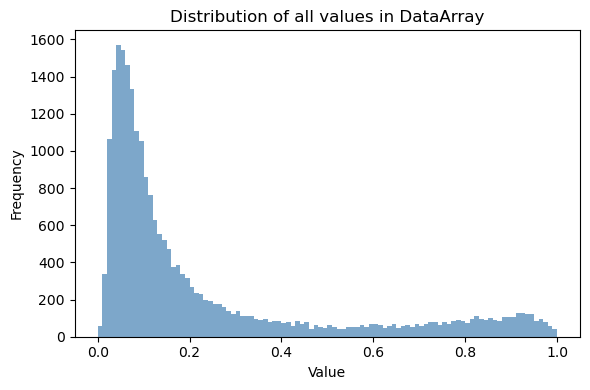

In [51]:
import matplotlib.pyplot as plt

# assume your DataArray is called da
plt.figure(figsize=(6, 4))
plt.hist(bulk_beta_sel.values.ravel(), bins=100, color="steelblue", alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of all values in DataArray")
plt.tight_layout()
plt.show()

In [52]:
order = order + ["Micro1", "Micro2"]
df_beta = bulk_beta_sel[bulk_beta_sel.index.isin(order)]
df_beta = df_beta.loc[order, sorted_columns]
# region_order = df_beta.idxmax(axis=0)
# region_order = pd.Categorical(region_order, categories=order, ordered=True)
# df_beta = df_beta.iloc[:, np.argsort(region_order.codes)]

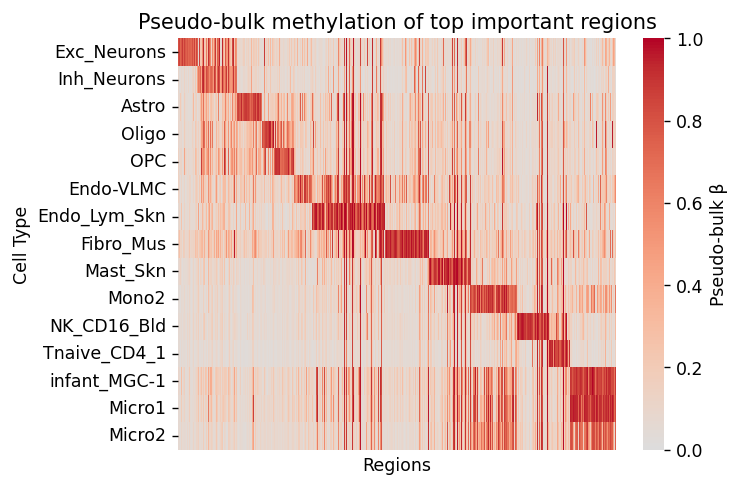

In [53]:
plt.figure(figsize=(6, 4), dpi=125)
sns.heatmap(
    df_beta,
    cmap="coolwarm",
    center=0,
    xticklabels=False,
    vmin=0, 
    vmax=1,
    cbar_kws={"label": "Pseudo-bulk β"},
)
plt.xlabel("Regions")
plt.ylabel("Cell Type")
plt.title("Pseudo-bulk methylation of top important regions")
plt.tight_layout()
plt.show()

In [62]:
order = included_ct

In [63]:
meta_sub = pd.read_csv("dmr_regions-CGN_hypo_score-meta_sub.tsv", sep="\t", header=0, index_col=0)
meta_sub["celltype"] = metadata.loc[meta_sub.index, "celltype"].copy()
meta_new_sub = metadata[~metadata.index.isin(meta_sub.index)]
nsample = 500
meta_new_sub = (
    meta_new_sub.groupby("celltype", group_keys=False).
        apply(lambda x: x.sample(n=min(len(x), nsample), random_state=42))
)
meta_new_sub = meta_new_sub[meta_new_sub["celltype"].isin(order)]

In [64]:
mcds_new_sub = mcds.sel(cell=meta_new_sub.index)

In [65]:
test_new = mcds_new_sub.get_score_adata(mc_type="CGN", quant_type="hypo-score")

Loading chunk 0-2822/2822


In [66]:
adata = sc.read_h5ad("dmr_regions-CGN_hypo_score.h5ad")
adata = adata[meta_sub[meta_sub["celltype"].isin(included_ct)].index, :].copy()
X = adata.X
y = meta_sub.loc[adata.obs_names, "celltype"].values
le = LabelEncoder()
y_numeric = le.fit_transform(y)

In [67]:
dtest = xgb.DMatrix(test_new.X, label=le.transform(test_new.obs["celltype"]))
best_iter = 9999
y_pred_proba = bst.predict(dtest, iteration_range=(0, best_iter + 1))
y_pred = np.argmax(y_pred_proba, axis=1)

In [68]:
labels = le.inverse_transform(np.unique(y_pred))

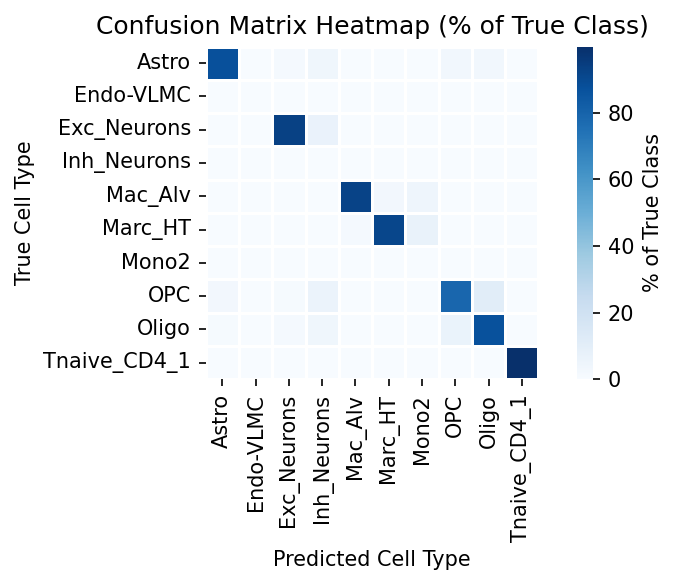

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create heatmap
cm = confusion_matrix(dtest.get_label(), y_pred, normalize="true") * 100
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df.loc[labels, labels]
plt.figure(figsize=(6, 4), dpi=150)
sns.heatmap(
    cm_df,
    cmap="Blues",
    cbar_kws={"label": "% of True Class"},
    square=True,
    annot=False,
    linewidths=0.5
)

plt.title("Confusion Matrix Heatmap (% of True Class)")
plt.xlabel("Predicted Cell Type")
plt.ylabel("True Cell Type")
plt.tight_layout()
plt.show()

# Rerun the model with important regions

In [10]:
bst = xgb.Booster()
bst.load_model("models/hypo-score_20251013.json")

In [11]:
importance = bst.get_score(importance_type="gain")
importance_df = (
    pd.DataFrame(list(importance.items()), columns=["feature", "importance"])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

In [12]:
topN = int(importance_df.shape[0] * 0.05)
importance_df["region"] = [adata.var_names[int(f[1:])] for f in importance_df["feature"]]
top_regions = importance_df["region"].head(topN).values

In [7]:
adata = sc.read_h5ad("dmr_regions-CGN_posterior_frac.h5ad")
metadata = pd.read_csv("dmr_regions-CGN_hypo_score-meta_sub_200.tsv", sep="\t", header=0, index_col=0)

In [8]:
metadata["ct_raw"] = metadata["celltype"].copy()
ext = ["CA", "DG", "SUB"]
metadata.loc[metadata["celltype"].isin(ext), "celltype"] = "Exc_Neurons"
inh = ["PVALB", "SST", "VIP", "NR2F2-LAMP5"]
metadata.loc[metadata["celltype"].isin(inh), "celltype"] = "Inh_Neurons"

In [9]:
included_ct = [
    "Exc_Neurons", "Inh_Neurons",
    "Astro", "Oligo", "OPC", "Endo-VLMC",
    "Endo_Lym_Skn", "Fibro_Mus", "Mast_Skn", "Mono2",
    "NK_CD16_Bld", "Tnaive_CD4_1", "infant_MGC-1"
]

In [13]:
adata = adata[:, top_regions]

In [14]:
adata

View of AnnData object with n_obs × n_vars = 4344 × 849
    obs: 'allc_path', 'celltype'
    var: 'chrom', 'end', 'start'

In [15]:
micro_adata = adata[metadata[metadata["celltype"].isin(["Micro1", "Micro2"])].index, :].copy()
adata = adata[metadata[metadata["celltype"].isin(included_ct)].index, :].copy()

In [16]:
X = adata.X
y = metadata.loc[adata.obs_names, "celltype"].values
le = LabelEncoder()
y_numeric = le.fit_transform(y)

In [17]:
le.classes_

array(['Astro', 'Endo-VLMC', 'Endo_Lym_Skn', 'Exc_Neurons', 'Fibro_Mus',
       'Inh_Neurons', 'Mast_Skn', 'Mono2', 'NK_CD16_Bld', 'OPC', 'Oligo',
       'Tnaive_CD4_1', 'infant_MGC-1'], dtype=object)

In [18]:
# Train: Eval: Test in 7:2:1 ratio
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_numeric, test_size=0.1, random_state=42, stratify=y_numeric
)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_temp, y_temp, test_size=2/9, random_state=42, stratify=y_temp
)

In [19]:
# Load data onto XGBoost GPU support
dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_eval, label=y_eval)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
## Accuracy calculation
num_classes = len(np.unique(y_numeric))
def accuracy_eval(preds, dmatrix):
    labels = dmatrix.get_label().astype(int)
    preds = preds.reshape(-1, num_classes)
    pred_labels = np.argmax(preds, axis=1)
    acc = np.mean(pred_labels == labels)
    return "accuracy", acc

In [21]:
print(num_classes)

13


In [22]:
print(len(metadata["celltype"].unique()))

25


## Training step

In [23]:
params = {
    "objective": "multi:softprob",
    "num_class": num_classes,
    "tree_method": "hist",
    "device": "cuda",
    "max_depth": 4,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.4,
    "reg_lambda": 1.0,
    "reg_alpha": 0.1,
    "eval_metric": "mlogloss",
    "random_state": 42
}

In [24]:
evals = [(dtrain, "train"), (deval, "eval")]
evals_result = {}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=evals,
    custom_metric=accuracy_eval,
    evals_result=evals_result,
    early_stopping_rounds=5000,
    verbose_eval=50
)

[0]	train-mlogloss:2.52464	train-accuracy:0.83540	eval-mlogloss:2.52946	eval-accuracy:0.72830
[50]	train-mlogloss:1.44264	train-accuracy:0.95251	eval-mlogloss:1.57596	eval-accuracy:0.88302
[100]	train-mlogloss:0.96302	train-accuracy:0.96006	eval-mlogloss:1.15419	eval-accuracy:0.89623
[150]	train-mlogloss:0.68157	train-accuracy:0.96330	eval-mlogloss:0.90041	eval-accuracy:0.89623
[200]	train-mlogloss:0.50088	train-accuracy:0.97140	eval-mlogloss:0.73096	eval-accuracy:0.90189
[250]	train-mlogloss:0.38002	train-accuracy:0.97410	eval-mlogloss:0.61362	eval-accuracy:0.90189
[300]	train-mlogloss:0.29635	train-accuracy:0.97787	eval-mlogloss:0.53073	eval-accuracy:0.90755
[350]	train-mlogloss:0.23671	train-accuracy:0.98057	eval-mlogloss:0.46970	eval-accuracy:0.90943
[400]	train-mlogloss:0.19306	train-accuracy:0.98543	eval-mlogloss:0.42385	eval-accuracy:0.91321
[450]	train-mlogloss:0.16006	train-accuracy:0.98867	eval-mlogloss:0.38985	eval-accuracy:0.91321
[500]	train-mlogloss:0.13457	train-accuracy

In [25]:
eval_logloss = evals_result["eval"]["mlogloss"]
best_iter = int(np.argmin(eval_logloss))
best_score = float(np.min(eval_logloss))

In [26]:
bst.save_model("models/hypo-score_20251013_rerun.json")

In [27]:
order = included_ct

In [28]:
y_pred_proba = bst.predict(dtest, iteration_range=(0, best_iter + 1))
y_pred = np.argmax(y_pred_proba, axis=1)

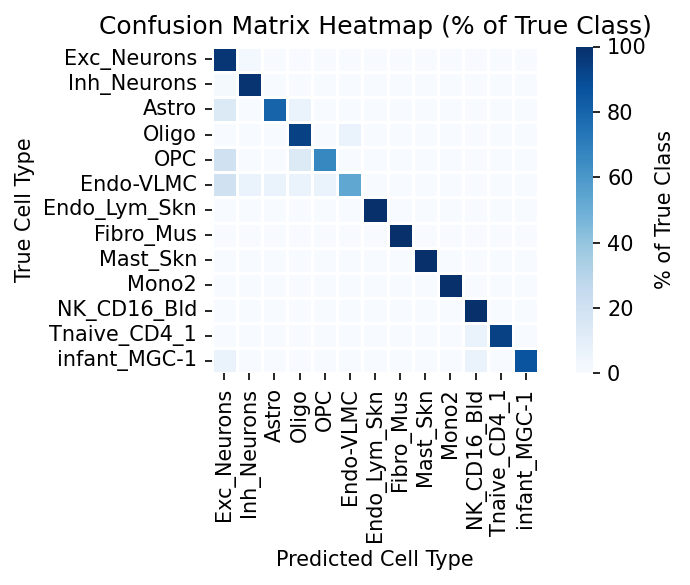

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create heatmap
cm = confusion_matrix(y_test, y_pred, normalize="true") * 100
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df = cm_df.loc[order, order]
plt.figure(figsize=(6, 4), dpi=150)
sns.heatmap(
    cm_df,
    cmap="Blues",
    cbar_kws={"label": "% of True Class"},
    square=True,
    annot=False,
    linewidths=0.5
)

plt.title("Confusion Matrix Heatmap (% of True Class)")
plt.xlabel("Predicted Cell Type")
plt.ylabel("True Cell Type")
plt.tight_layout()
plt.show()

In [30]:
dmicro = xgb.DMatrix(micro_adata.X)

In [31]:
micro_pred_prob = bst.predict(dmicro, iteration_range=(0, best_iter + 1))
micro_pred = np.argmax(micro_pred_prob, axis=1)

In [32]:
pred_df = pd.DataFrame({
    "cell_id": micro_adata.obs_names,
    "true_type": metadata.loc[micro_adata.obs_names, "celltype"],
    "predicted_type": le.inverse_transform(micro_pred),
})

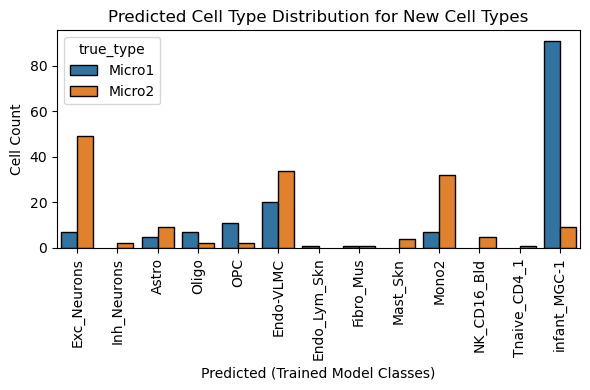

In [33]:
plt.figure(figsize=(6, 4))
sns.countplot(data=pred_df, x="predicted_type", hue="true_type", order=order, edgecolor="black")
plt.title("Predicted Cell Type Distribution for New Cell Types")
plt.xlabel("Predicted (Trained Model Classes)")
plt.ylabel("Cell Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()